### Install Library

In [1]:
!pip install -q -U watermark

In [2]:
!pip install transformers==2.11.0

In [3]:
!pip install columnize

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.8.3
IPython 7.16.1

numpy 1.18.5
pandas 1.0.5
torch 1.6.0
transformers 2.11.0


### Import Library

In [5]:
import ast
import columnize
import emoji 
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

### Common Configuration Set-Up

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Exploratory Data Analysis

In [7]:
# df = pd.read_csv("data/tweet_emoji_dev_1000.csv")
df = pd.read_csv("data/tweet_emoji_train_40000.csv")
df = df.head(5000)
df.head()

,id,tweet,emoji
0,0,CeeC is going to be another Tboss What is 45 million Naira,['face_with_tears_of_joy']
1,1,This gif kills me Death is literally gushing towards you and you really gon do a whole 3point turn,['weary_face']
2,2,LOVE TEST Raw Real JaDine,['purple_heart']
3,3,i swear we dont gotta look it finds us,['face_with_tears_of_joy']
4,4,We would like to wish everyone a very Happy New Year and all the best in 2018,['party_popper']


In [8]:
df = df.drop('id', 1)
df = df.drop_duplicates(subset=['tweet'], keep=False)
df = df.dropna(how='any',axis=0) 
df.reset_index(inplace=True)
df.index.rename('id', inplace=True)
df = df.drop('index', 1)

In [9]:
print('Contains only unique tweets: ', df.tweet.nunique() == df.shape[0])
print('Contains Null values: ', df.isnull().values.any())

Contains only unique tweets:  True
Contains Null values:  False


In [10]:
df['emoji'] = df['emoji'].apply(lambda x: set(ast.literal_eval(x)))
df.emoji= df.emoji.apply(list)
df.head()

,tweet,emoji
id,,
0,CeeC is going to be another Tboss What is 45 million Naira,[face_with_tears_of_joy]
1,This gif kills me Death is literally gushing towards you and you really gon do a whole 3point turn,[weary_face]
2,LOVE TEST Raw Real JaDine,[purple_heart]
3,We would like to wish everyone a very Happy New Year and all the best in 2018,[party_popper]
4,15000 retweets a new song song off Swaecation part 2 of unforgettable go,[speaking_head]


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4827 entries, 0 to 4826
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   4827 non-null   object
 1   emoji   4827 non-null   object
dtypes: object(2)
memory usage: 75.5+ KB


In [12]:
# helper functions to get the distinct emoji in the dataset
def get_distinct_emoji(emoji_column:pd.core.series.Series)->set:
    emoji_set = set()
    for emojis in emoji_column:
        for x in emojis: 
            emoji_set.add(x)
    return emoji_set

def print_distinct_emoji_in_dataset(emoji_set:set):
    print('Total distinct count of Emojis in dataset is : {}'.format(len(emoji_set)))
    emoji_set_formatted = [emoji.emojize(':'+ e +':') for e in emoji_set]
    print(columnize.columnize(emoji_set_formatted, displaywidth=20))
        
emoji_class = get_distinct_emoji(df.emoji)
print_distinct_emoji_in_dataset(emoji_class)

Total distinct count of Emojis in dataset is : 49
💛  ➡  ♂  🎉  💜  ✨  ✅
🚨  😁  👇  🗣  👍  ❤  😢
👉  🤷  💙  💀  🙏  ‼  ♀
😂  😉  🤦  ♥  🏆  😊  💖
👏  💥  😘  😳  🤔  👀  💪
💯  😩  ✔  😍  👌  😎  😭
🙄  🤣  🔥  🙌  💕  🌟  ☺



In [13]:
df_multiclass_dataset = df[df['emoji'].apply(lambda x: len(x)==1)].copy()
df_multiclass_dataset['label'] = df_multiclass_dataset['emoji'].apply(lambda x: x[0])

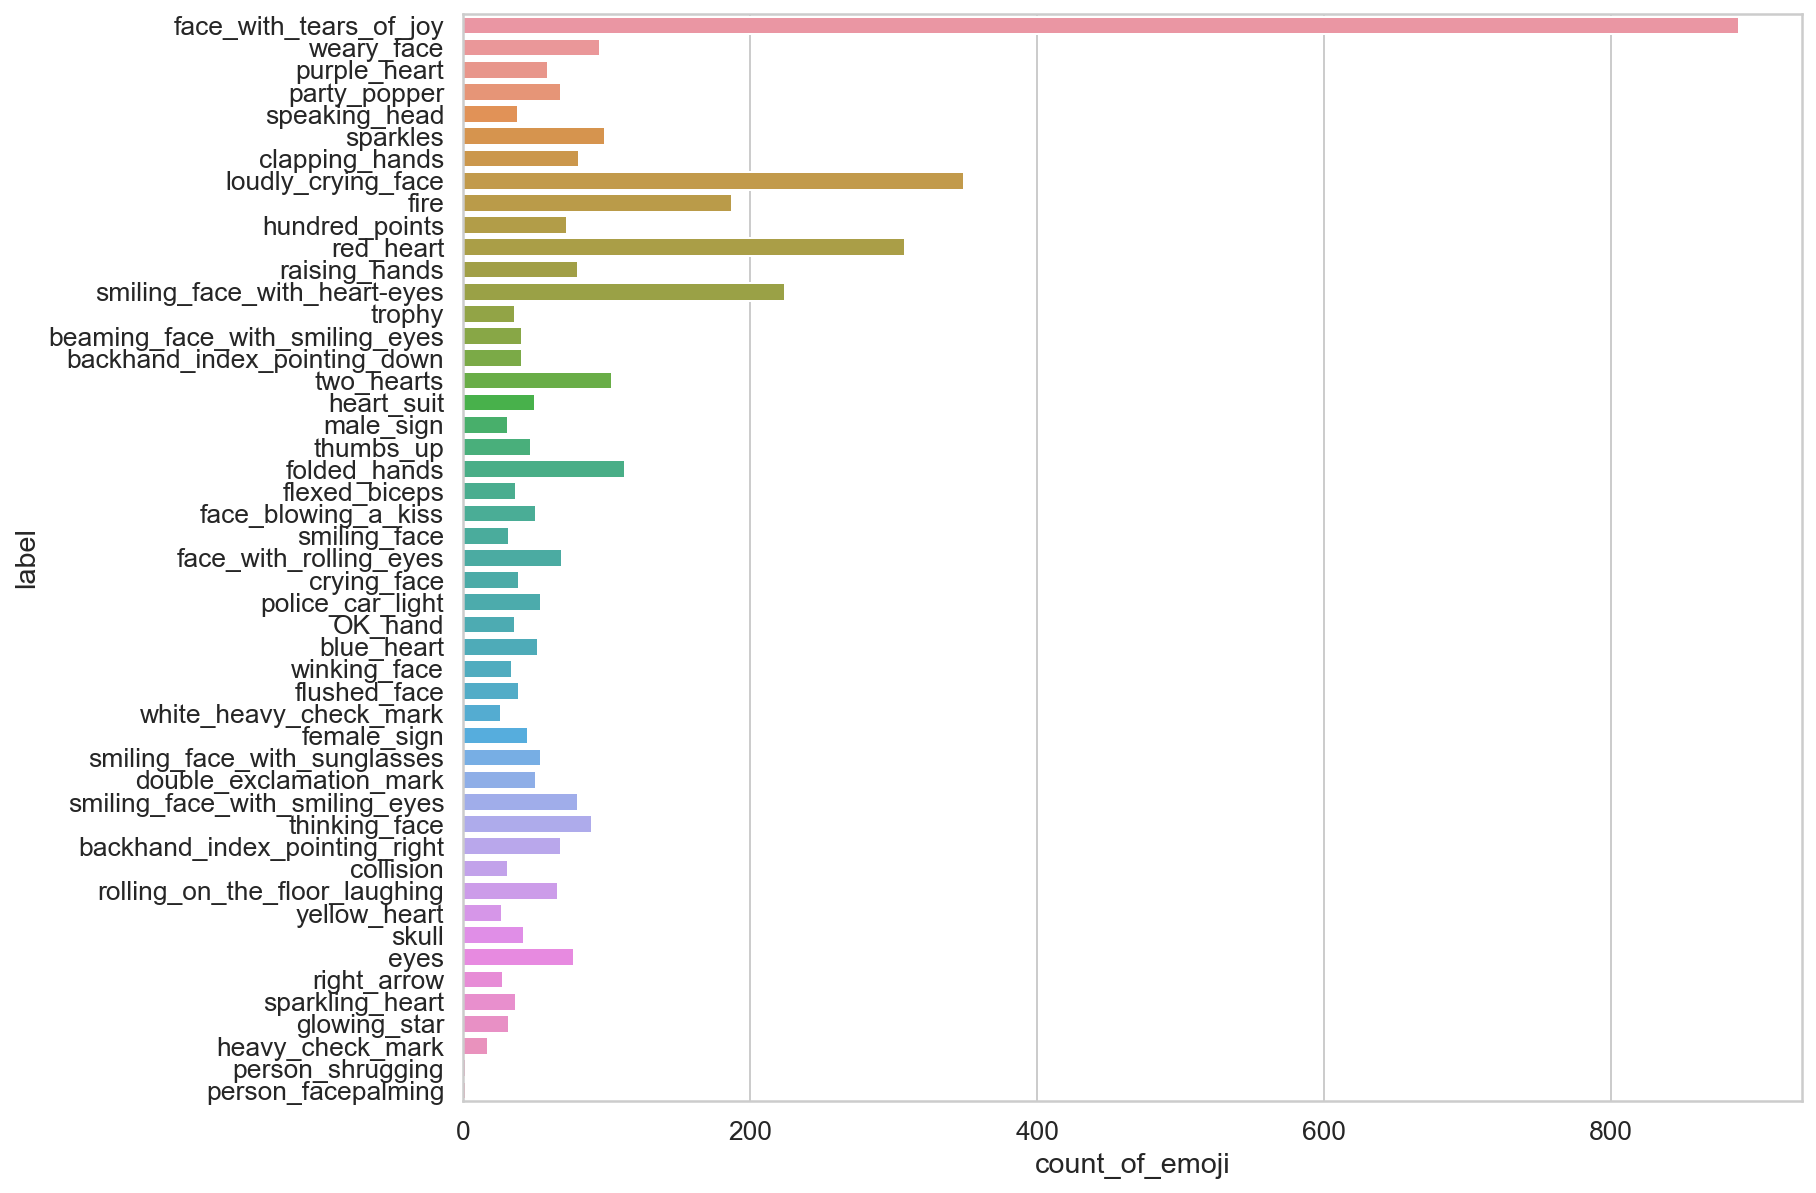

In [14]:
sns.countplot(y="label", data=df_multiclass_dataset)
plt.xlabel('count_of_emoji');

In [15]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df_multiclass_dataset['target'] = label_encoder.fit_transform(df_multiclass_dataset['label'])

df_multiclass_dataset.head()

,tweet,emoji,label,target
id,,,,
0,CeeC is going to be another Tboss What is 45 million Naira,[face_with_tears_of_joy],face_with_tears_of_joy,12
1,This gif kills me Death is literally gushing towards you and you really gon do a whole 3point turn,[weary_face],weary_face,45
2,LOVE TEST Raw Real JaDine,[purple_heart],purple_heart,28
3,We would like to wish everyone a very Happy New Year and all the best in 2018,[party_popper],party_popper,24
4,15000 retweets a new song song off Swaecation part 2 of unforgettable go,[speaking_head],speaking_head,40


In [16]:
df_multiclass_dataset['inverse_encoder'] = label_encoder.inverse_transform(df_multiclass_dataset['target'])
df_multiclass_dataset.head()

,tweet,emoji,label,target,inverse_encoder
id,,,,,
0,CeeC is going to be another Tboss What is 45 million Naira,[face_with_tears_of_joy],face_with_tears_of_joy,12,face_with_tears_of_joy
1,This gif kills me Death is literally gushing towards you and you really gon do a whole 3point turn,[weary_face],weary_face,45,weary_face
2,LOVE TEST Raw Real JaDine,[purple_heart],purple_heart,28,purple_heart
3,We would like to wish everyone a very Happy New Year and all the best in 2018,[party_popper],party_popper,24,party_popper
4,15000 retweets a new song song off Swaecation part 2 of unforgettable go,[speaking_head],speaking_head,40,speaking_head


### Data Pre-processing

* Add special tokens to seperate setences and do classification 
* Pass sequences of constant length using padding 
* Create array of 0s and 1s called attention mask 

In [17]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' # case sensitive

In [18]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [19]:
sample_txt = 'ranks 6th in January Idol Group Brand Reputation 1Keep using 2Search GOT 7 on Naver htt'

In [20]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: ranks 6th in January Idol Group Brand Reputation 1Keep using 2Search GOT 7 on Naver htt
   Tokens: ['ranks', '6th', 'in', 'January', 'Idol', 'Group', 'Brand', 'Rep', '##uta', '##tion', '1', '##K', '##eep', 'using', '2', '##S', '##ear', '##ch', 'GO', '##T', '7', 'on', 'Na', '##ver', 'h', '##tt']
Token IDs: [6496, 4584, 1107, 1356, 15632, 1990, 12381, 20777, 15012, 2116, 122, 2428, 17059, 1606, 123, 1708, 19386, 1732, 27157, 1942, 128, 1113, 11896, 4121, 177, 3069]


In [21]:
tokenizer.sep_token, tokenizer.sep_token_id # special token '[SEP]' is the marker for ending of a sentence 

('[SEP]', 102)

In [22]:
tokenizer.cls_token, tokenizer.cls_token_id # special token '[CLS]' is the marker for the start of each sentence 

('[CLS]', 101)

In [23]:
tokenizer.pad_token, tokenizer.pad_token_id # special token '[PAD]' is the marker for padding

('[PAD]', 0)

In [24]:
tokenizer.unk_token, tokenizer.unk_token_id # special token '[UNK]' for vocabulary that is not in the training set

('[UNK]', 100)

In [25]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [26]:
encoding['input_ids'][0]

tensor([  101,  6496,  4584,  1107,  1356, 15632,  1990, 12381, 20777, 15012,
         2116,   122,  2428, 17059,  1606,   123,  1708, 19386,  1732, 27157,
         1942,   128,  1113, 11896,  4121,   177,  3069,   102,     0,     0,
            0,     0])

In [27]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'ranks',
 '6th',
 'in',
 'January',
 'Idol',
 'Group',
 'Brand',
 'Rep',
 '##uta',
 '##tion',
 '1',
 '##K',
 '##eep',
 'using',
 '2',
 '##S',
 '##ear',
 '##ch',
 'GO',
 '##T',
 '7',
 'on',
 'Na',
 '##ver',
 'h',
 '##tt',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [28]:
token_lens = []

for txt in df.tweet:
    tokens = tokenizer.encode(txt, max_length=200)
    token_lens.append(len(tokens))

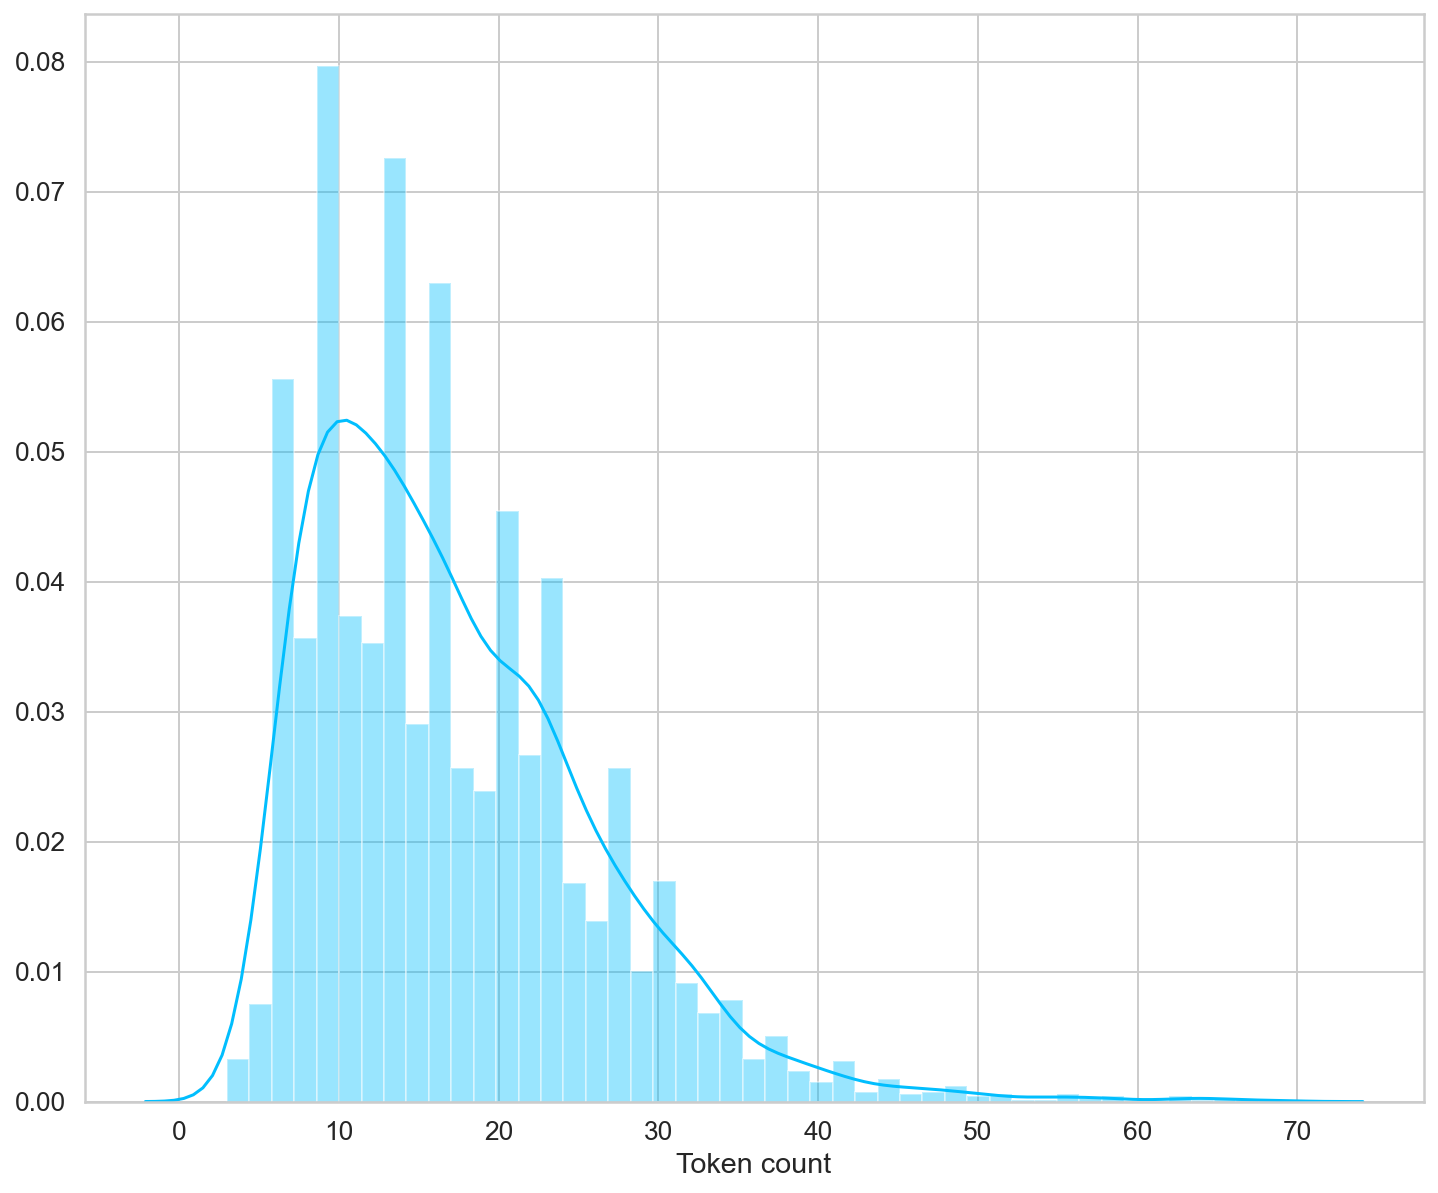

In [29]:
sns.distplot(token_lens)
plt.xlabel('Token count');

In [30]:
MAX_LEN = 60

### Create PyTorch Dataset

In [31]:
class GPTweetDataset(Dataset):
    def __init__(self, tweet, target, tokenizer, max_len):
        self.tweet = tweet
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self, item):
        tweet = str(self.tweet[item])
        target = self.target[item]
        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'target': torch.tensor(target, dtype=torch.long)
        }

In [32]:
df_train, df_test = train_test_split(df_multiclass_dataset, test_size=0.1,\
                                     random_state=RANDOM_SEED, stratify=df_multiclass_dataset['label'])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [33]:
df_train.shape, df_val.shape, df_test.shape

((3807, 5), (211, 5), (212, 5))

In [34]:
df_train.head()

,tweet,emoji,label,target,inverse_encoder
id,,,,,
2841,KONSTAGRAM withikonic IG story update of Hanbin D3 to iKONs Comeback,[two_hearts],two_hearts,44,two_hearts
2136,bruhhh Blac Youngsta is a clown,[face_with_tears_of_joy],face_with_tears_of_joy,12,face_with_tears_of_joy
1748,Dont worry guys am chilled,[face_with_tears_of_joy],face_with_tears_of_joy,12,face_with_tears_of_joy
2906,I LOVE YOU BTS forever you will be in my heart Congratulations,[purple_heart],purple_heart,28,purple_heart
4558,Are u sure they didnt drop hints for the next ALBUMCOMEBACK,[face_with_tears_of_joy],face_with_tears_of_joy,12,face_with_tears_of_joy


In [35]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPTweetDataset(
        tweet=df.tweet.to_numpy(),
        target=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0)

In [36]:
BATCH_SIZE = 10

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [37]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'target'])

In [38]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['target'].shape)

torch.Size([10, 60])
torch.Size([10, 60])
torch.Size([10])


### Emoji Classifier

In [39]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [40]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [41]:
class EmojiClassifier(nn.Module):
    def __init__(self, n_classes):
        super(EmojiClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.1)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

In [42]:
model = EmojiClassifier(len(emoji_class))
model = model.to(device)

In [43]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([10, 60])
torch.Size([10, 60])


In [44]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.0269, 0.0098, 0.0297, 0.0123, 0.0356, 0.0106, 0.0132, 0.0109, 0.0264,
         0.0147, 0.0234, 0.0106, 0.0358, 0.0162, 0.0620, 0.0214, 0.0134, 0.0176,
         0.0092, 0.0355, 0.0176, 0.0119, 0.0193, 0.0123, 0.0529, 0.0105, 0.0581,
         0.0232, 0.0132, 0.0115, 0.0098, 0.0110, 0.0243, 0.0087, 0.0191, 0.0151,
         0.0146, 0.0184, 0.0136, 0.0164, 0.0208, 0.0251, 0.0128, 0.0168, 0.0204,
         0.0204, 0.0148, 0.0154, 0.0367],
        [0.0364, 0.0152, 0.0285, 0.0124, 0.0210, 0.0062, 0.0101, 0.0134, 0.0203,
         0.0120, 0.0242, 0.0092, 0.0419, 0.0211, 0.0459, 0.0190, 0.0154, 0.0210,
         0.0108, 0.0327, 0.0214, 0.0171, 0.0371, 0.0162, 0.0371, 0.0090, 0.0666,
         0.0359, 0.0113, 0.0080, 0.0122, 0.0086, 0.0253, 0.0078, 0.0153, 0.0124,
         0.0123, 0.0155, 0.0122, 0.0120, 0.0138, 0.0216, 0.0100, 0.0144, 0.0282,
         0.0350, 0.0155, 0.0148, 0.0368],
        [0.0371, 0.0110, 0.0290, 0.0135, 0.0206, 0.0080, 0.0094, 0.0121, 0.0349,
         0.0131, 0.0290, 

### Train Model

In [45]:
EPOCHS = 6

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [46]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["target"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [47]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["target"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [48]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train))
    
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val))
    
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/6
----------
Train loss 3.323429882995726 accuracy 0.20541108484370896
Val   loss 3.2559019218791616 accuracy 0.23696682464454977

Epoch 2/6
----------
Train loss 3.074980649735358 accuracy 0.2406094037299711
Val   loss 3.2186600511724297 accuracy 0.22274881516587677

Epoch 3/6
----------
Train loss 2.7654682645021773 accuracy 0.2970843183609141
Val   loss 3.2521080645647915 accuracy 0.2132701421800948

Epoch 4/6
----------
Train loss 2.4629531247722194 accuracy 0.37063304439190964
Val   loss 3.3618566773154517 accuracy 0.22274881516587677

Epoch 5/6
----------
Train loss 2.221089672228796 accuracy 0.4315734173890202
Val   loss 3.4256413633173164 accuracy 0.22274881516587677

Epoch 6/6
----------
Train loss 2.0854526052637676 accuracy 0.46782243236143944
Val   loss 3.4606045376170766 accuracy 0.24170616113744076

CPU times: user 3h 19min 43s, sys: 14min 44s, total: 3h 34min 27s
Wall time: 1h 58min 15s


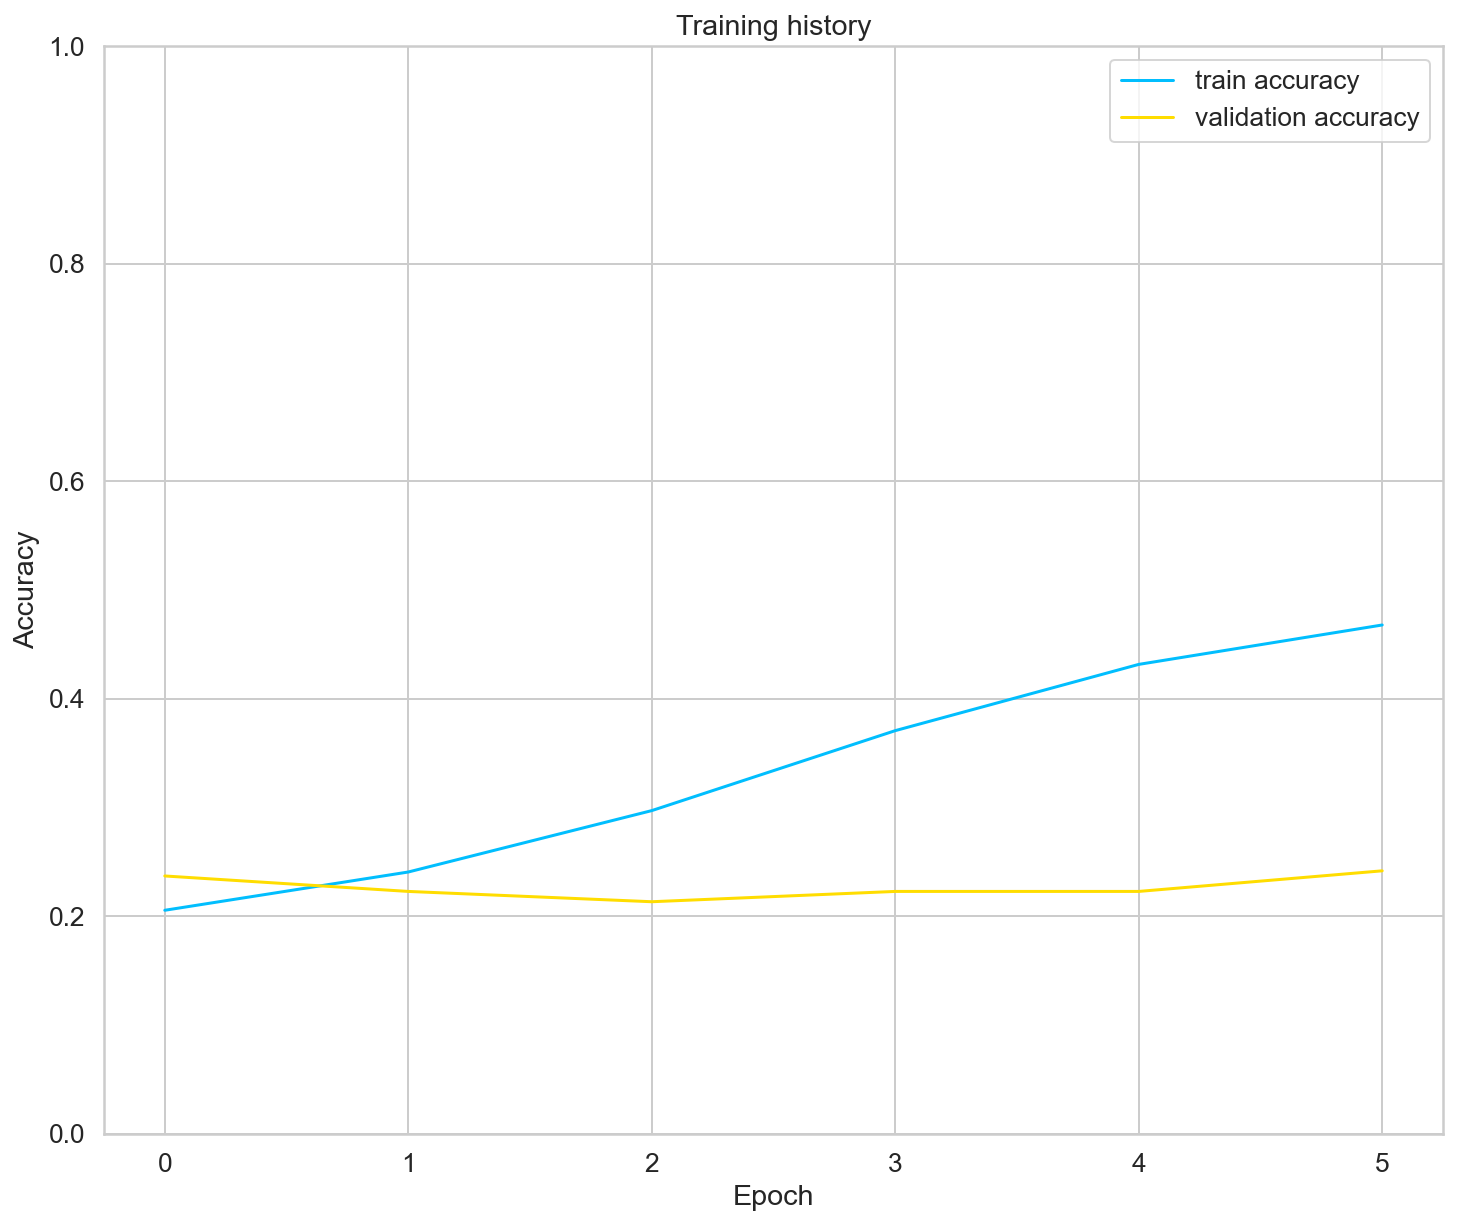

In [49]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluate 

In [50]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.24056603773584906

In [51]:
def get_predictions(model, data_loader):
    model = model.eval()
    tweet_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            texts = d["tweet_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["target"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = nn.functional.softmax(outputs, dim=1)
            tweet_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)
        
        predictions = torch.stack(predictions).cpu()
        prediction_probs = torch.stack(prediction_probs).cpu()
        real_values = torch.stack(real_values).cpu()
        return tweet_texts, predictions, prediction_probs, real_values

In [52]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_data_loader)

In [53]:
y_tweet_texts

['this is the sweetest thing thank you for bringing positivity to our school and community youre amazing httpst',
 'Cdot Honcho Pray otw',
 'LMFAO whoever did these edits is stupid',
 'Daughters Special gift to her dad',
 'Someone said Stop posting Black Panther on your wall if youre bleaching youre a confused Panther ',
 'START LOOOL this is a sick idea Pioneer',
 'I LOVE THIS VIDEO',
 'dont you just love it when you look at jungkooks eyes and theyre like',
 'START GUYS CALL AND REQUEST WANT YOU BACK TO YOUR LOCAL RADIO STATIONS',
 'rt this to gain namjoon stan mutuals follow everyone who retweets this and make sure to follow back',
 'I always want to do but I never seem to have the time',
 'NAMJOON DAY rt if u love taehyung follow whoever rts',
 'i cant stop laughing jungkook started flipping his hair because armys told him his hoodie made him look like he had lon',
 'Lets gain Gain 100 more Quick Followers 1 Retweet Real Quick 2 Follow all that Retweet 3 Follow back all that fo',
 '

In [54]:
label_encoder.inverse_transform(y_pred.detach().cpu().numpy())

array(['red_heart', 'face_with_tears_of_joy', 'face_with_tears_of_joy',
       'red_heart', 'face_with_tears_of_joy', 'face_with_tears_of_joy',
       'loudly_crying_face', 'smiling_face_with_heart-eyes',
       'police_car_light', 'fire', 'loudly_crying_face', 'red_heart',
       'face_with_tears_of_joy', 'backhand_index_pointing_right',
       'face_with_tears_of_joy', 'face_with_tears_of_joy',
       'face_with_tears_of_joy', 'face_with_tears_of_joy',
       'face_with_tears_of_joy', 'police_car_light', 'police_car_light',
       'fire', 'eyes', 'face_with_tears_of_joy', 'face_with_tears_of_joy',
       'red_heart', 'loudly_crying_face', 'red_heart',
       'face_with_tears_of_joy', 'fire', 'weary_face', 'fire',
       'face_with_tears_of_joy', 'face_with_tears_of_joy',
       'face_with_tears_of_joy', 'fire', 'backhand_index_pointing_right',
       'loudly_crying_face', 'red_heart', 'red_heart',
       'smiling_face_with_smiling_eyes', 'smiling_face_with_heart-eyes',
       'clappi

In [55]:
label_encoder.inverse_transform(y_test.detach().cpu().numpy())

array(['red_heart', 'sparkles', 'loudly_crying_face', 'red_heart',
       'loudly_crying_face', 'face_with_tears_of_joy',
       'face_with_tears_of_joy', 'glowing_star', 'raising_hands', 'eyes',
       'crying_face', 'purple_heart', 'face_with_tears_of_joy', 'fire',
       'face_with_tears_of_joy', 'winking_face', 'thinking_face', 'fire',
       'loudly_crying_face', 'police_car_light', 'glowing_star',
       'flexed_biceps', 'smiling_face_with_heart-eyes',
       'face_with_tears_of_joy', 'face_with_tears_of_joy', 'folded_hands',
       'weary_face', 'face_with_tears_of_joy', 'face_with_tears_of_joy',
       'white_heavy_check_mark', 'thinking_face',
       'double_exclamation_mark', 'face_with_tears_of_joy',
       'loudly_crying_face', 'backhand_index_pointing_down', 'weary_face',
       'heavy_check_mark', 'weary_face', 'face_with_tears_of_joy',
       'sparkles', 'face_with_tears_of_joy', 'male_sign', 'thumbs_up',
       'collision', 'loudly_crying_face', 'flushed_face', 'red_hea

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.25      0.33      0.29         3
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         4
           9       0.25      0.17      0.20         6
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         4
          12       0.43      0.59      0.50        49
          13       0.00      0.00      0.00         2
          14       0.04      0.09      0.06        11
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         3
          17       0.00    

/opt/anaconda3/envs/nlu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
